In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from gensim.models import Word2Vec
from joblib import load, dump

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

In [4]:
path_sentiment_data    = "../Data/PREP/sentiment_full.parquet"
path_merger_data       = "../Data/MERGERS/mergers.csv"

path_modelo_w2v        = '../Data/MODELS/modelo_word2vec_100.model'
path_modelo_clustering = '../Data/MODELS/clustering_pipeline.joblib'
path_modelo_logreg     = '../Data/MODELS/merger_logreg.joblib'

In [5]:
data = pd.read_parquet(path_sentiment_data)

In [6]:
def refactor_data(data):
    return (data
            .reset_index()
            .rename(columns={'sentences':'phrase', 'page':'n_page', 'sentence':'n_phrase'},)
            .set_index(['bank','year', 'n_page', 'n_phrase']))

def get_top_positive_phrases(data, count=20):
    data = refactor_data(data)
    preview = data.sort_values(by='positive', ascending=False).head(count)[['phrase']]
    return preview

def get_top_negative_phrases(data, count=20):
    data = refactor_data(data)
    preview = data.sort_values(by='negative', ascending=False).head(count)[['phrase']]
    return preview

def palabra_en_modelo(palabra,w2v):
    try:
        w2v.wv.get_vector(palabra)
        return True
    except:
        return False

def vectorize_text(texto_vector, w2v, SIZE_VECTORS=100):
    # Complete here the code
    vectors = [w2v.wv.get_vector(i) for i in texto_vector if palabra_en_modelo(i,w2v)]
    return np.mean(vectors, axis=0) if len(vectors) else np.zeros(SIZE_VECTORS)

def prepare_dataset(data, path_word2vec, path_clustering, SIZE_VECTORS=100):
    import numpy as np
    import pandas as pd
    from tqdm import tqdm
    tqdm.pandas()
    data = refactor_data(data)
    
    word2vec = Word2Vec.load(path_modelo_w2v)
    print('Tokenizing...')
    data['texto_vector'] = data.phrase.progress_apply(lambda x: [w.lower() for w in x.split(' ') if w])
    print('Aplicando Word2Vec...')
    vectors = data.texto_vector.progress_apply(lambda x: vectorize_text(x, word2vec, SIZE_VECTORS)).to_numpy()
    
    dfVectors = pd.DataFrame(np.concatenate(vectors).reshape(vectors.shape[0],SIZE_VECTORS,), index=data.index, 
                         columns=[f'WV{i}' for i in range(SIZE_VECTORS)])
    print('Aplicando Clustering...')
    clustering = load(path_modelo_clustering)
    clusters = clustering.predict(dfVectors)
    data['cluster'] = clusters
    data = data.dropna()
    print('Preparando Dataset...')
    ml_df = data.reset_index().groupby(['bank','year','cluster']).mean()[['positive','negative']].unstack('cluster')
    ml_df.columns = [sent[:3]+'_cluster_'+str(cluster)  for sent, cluster in ml_df.columns.values]
    ml_df = ml_df.fillna(0.0)
    
    return ml_df

def get_mergers(ml_df, path_merger_data):
    df_mergers = pd.read_csv(path_merger_data).dropna()
    df_mergers['YEAR'] = df_mergers['YEAR'].astype('int')
    df_mergers = df_mergers.set_index('YEAR')
    
    merger_target = []
    for bank, year in ml_df.index:
        merger_target.append(int(df_mergers[bank][int(year)]))
        
    return merger_target

def predict_merger(data, 
                   path_modelo_word2vec,
                   path_modelo_clustering,
                   path_modelo_merger,
                   timeit=True
                  ):
    import time
    from joblib import load
    total_time = 0
    if timeit: 
        start = time.time()
    X = prepare_dataset(data, path_modelo_word2vec, path_modelo_clustering)
    # Load del modelo:
    print('Cargando Modelo...')
    model = load(path_modelo_merger)
    print('Haciendo Predicción...')
    merger_pred = model.predict_proba(X)[:,1]
    if timeit: 
        end = time.time()
        total_time = end - start
        
    return merger_pred, total_time

In [286]:
# X = prepare_dataset(data, path_modelo_w2v, path_modelo_clustering)
# y = get_mergers(X, path_merger_data)

In [34]:
# X.drop(columns='m&a', inplace=True)

In [282]:
# X['y'] = y
# X.to_csv('final_dataset.csv')

In [346]:
X = pd.read_csv('final_dataset.csv').set_index(['bank','year'])
# y = X.pop('y')

In [347]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

X_pos = X[X.y == 1].drop(columns='y')
X_neg = X[X.y == 0].drop(columns='y')

bandwidth_params = {'bandwidth': np.arange(0.01,1,0.05)}
pos_grid_search = GridSearchCV(KernelDensity(), bandwidth_params)
pos_grid_search.fit(X_pos)
pos_kde = pos_grid_search.best_estimator_

In [349]:
pos_samples = pos_kde.sample(10000,random_state=42)
pos_samples = np.where(pos_samples > 0, pos_samples, 0.0)
pos_samples = np.where(pos_samples < 1, pos_samples, 1.0)

In [351]:
y = X.pop('y')
X = np.concatenate([X,pos_samples])
y = np.concatenate([y,np.zeros(10000)])

In [352]:
X.shape

(10222, 10)

In [353]:
sm = SMOTE(random_state=42, sampling_strategy=1)
X, y = sm.fit_resample(X, y)

In [354]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)

In [355]:
pd.Series(y_train).value_counts()

1.0    8174
0.0    8163
dtype: int64

# Autoencoder

In [356]:
import tensorflow as tf

In [357]:
input_layer = tf.keras.layers.Input(shape=10,)

x = tf.keras.layers.Dense(20, activation='tanh')(input_layer)
x = tf.keras.layers.Dropout(1/10)(x)
x = tf.keras.layers.Dense(15, activation='tanh')(x)
x = tf.keras.layers.Dropout(2/15)(x)
x = tf.keras.layers.Dense(10, activation='tanh')(x)
x = tf.keras.layers.Dropout(1/10)(x)
x = tf.keras.layers.Dense(8, activation='tanh')(x)
x = tf.keras.layers.Dense(5, activation='tanh')(x)

encoder = tf.keras.Model(inputs=input_layer, outputs=x)

In [358]:
input_layer = tf.keras.layers.Input(shape=5,)

x = tf.keras.layers.Dense(8, activation='tanh')(input_layer)
x = tf.keras.layers.Dense(10, activation='tanh')(x)
x = tf.keras.layers.Dense(15, activation='tanh')(x)
x = tf.keras.layers.Dense(20, activation='tanh')(x)
x = tf.keras.layers.Dense(10)(x)

decoder = tf.keras.Model(inputs=input_layer, outputs=x)

In [359]:
input_layer = tf.keras.layers.Input(shape=10,)

x = encoder(input_layer)
x = decoder(x)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=x)

In [360]:
autoencoder.compile(optimizer='adam',
                    loss='binary_crossentropy',metrics=['mse','mae'])

In [361]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=100),
    tf.keras.callbacks.ModelCheckpoint('best_autoencoder.h5',monitor="val_loss",)
]

In [362]:
history = autoencoder.fit(X_train, X_train, validation_data=(X_test, X_test), epochs=5000, callbacks=callbacks)

Epoch 1/5000
511/511 [==============================] - 2s 2ms/step - loss: 0.2052 - mse: 0.0040 - mae: 0.0434 - val_loss: 0.1724 - val_mse: 0.0012 - val_mae: 0.0257
Epoch 2/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1718 - mse: 0.0012 - mae: 0.0245 - val_loss: 0.1738 - val_mse: 0.0013 - val_mae: 0.0259
Epoch 3/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1737 - mse: 0.0014 - mae: 0.0265 - val_loss: 0.1710 - val_mse: 0.0011 - val_mae: 0.0244
Epoch 4/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1722 - mse: 0.0013 - mae: 0.0252 - val_loss: 0.1686 - val_mse: 8.9997e-04 - val_mae: 0.0211
Epoch 5/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1805 - mse: 0.0032 - mae: 0.0323 - val_loss: 0.2000 - val_mse: 0.0065 - val_mae: 0.0547
Epoch 6/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1808 - mse: 0.0021 - mae: 0.0330 - val_loss: 0.1721 - val_mse: 0.0011 - val_mae: 0.0241


511/511 [==============================] - 1s 2ms/step - loss: 0.1720 - mse: 0.0017 - mae: 0.0256 - val_loss: 0.1691 - val_mse: 0.0010 - val_mae: 0.0215
Epoch 50/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1777 - mse: 0.0023 - mae: 0.0310 - val_loss: 0.1699 - val_mse: 9.6757e-04 - val_mae: 0.0217
Epoch 51/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1762 - mse: 0.0018 - mae: 0.0299 - val_loss: 0.1691 - val_mse: 9.2745e-04 - val_mae: 0.0208
Epoch 52/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1695 - mse: 0.0011 - mae: 0.0223 - val_loss: 0.1688 - val_mse: 8.9932e-04 - val_mae: 0.0211
Epoch 53/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1685 - mse: 9.4503e-04 - mae: 0.0209 - val_loss: 0.1672 - val_mse: 8.1894e-04 - val_mae: 0.0192
Epoch 54/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1680 - mse: 9.6869e-04 - mae: 0.0208 - val_loss: 0.1668 - val_mse: 8.2062e-04 - 

511/511 [==============================] - 1s 1ms/step - loss: 0.1696 - mse: 0.0011 - mae: 0.0226 - val_loss: 0.1673 - val_mse: 8.2306e-04 - val_mae: 0.0191
Epoch 98/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1700 - mse: 0.0011 - mae: 0.0224 - val_loss: 0.1669 - val_mse: 7.7432e-04 - val_mae: 0.0183
Epoch 99/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1688 - mse: 0.0011 - mae: 0.0221 - val_loss: 0.1664 - val_mse: 7.7644e-04 - val_mae: 0.0182
Epoch 100/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1707 - mse: 0.0012 - mae: 0.0240 - val_loss: 0.1706 - val_mse: 0.0010 - val_mae: 0.0231
Epoch 101/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1718 - mse: 0.0017 - mae: 0.0258 - val_loss: 0.1693 - val_mse: 0.0012 - val_mae: 0.0227
Epoch 102/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1691 - mse: 0.0011 - mae: 0.0226 - val_loss: 0.1677 - val_mse: 8.4436e-04 - val_mae: 

511/511 [==============================] - 1s 2ms/step - loss: 0.1678 - mse: 9.3421e-04 - mae: 0.0207 - val_loss: 0.1688 - val_mse: 8.7471e-04 - val_mae: 0.0207
Epoch 145/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1683 - mse: 0.0010 - mae: 0.0214 - val_loss: 0.1674 - val_mse: 9.3819e-04 - val_mae: 0.0205
Epoch 146/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1677 - mse: 8.9856e-04 - mae: 0.0203 - val_loss: 0.1672 - val_mse: 7.7371e-04 - val_mae: 0.0188
Epoch 147/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1670 - mse: 8.5266e-04 - mae: 0.0194 - val_loss: 0.1715 - val_mse: 0.0011 - val_mae: 0.0235
Epoch 148/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1670 - mse: 8.6697e-04 - mae: 0.0194 - val_loss: 0.1659 - val_mse: 6.9607e-04 - val_mae: 0.0174
Epoch 149/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1689 - mse: 0.0010 - mae: 0.0219 - val_loss: 0.1671 - val_mse: 

511/511 [==============================] - 1s 2ms/step - loss: 0.1693 - mse: 0.0013 - mae: 0.0227 - val_loss: 0.1720 - val_mse: 0.0015 - val_mae: 0.0256
Epoch 192/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1685 - mse: 0.0011 - mae: 0.0219 - val_loss: 0.1657 - val_mse: 7.5688e-04 - val_mae: 0.0176
Epoch 193/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1664 - mse: 8.0462e-04 - mae: 0.0188 - val_loss: 0.1651 - val_mse: 6.5730e-04 - val_mae: 0.0167
Epoch 194/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1660 - mse: 8.0099e-04 - mae: 0.0183 - val_loss: 0.1745 - val_mse: 0.0022 - val_mae: 0.0296
Epoch 195/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1712 - mse: 0.0013 - mae: 0.0245 - val_loss: 0.1668 - val_mse: 7.6218e-04 - val_mae: 0.0181
Epoch 196/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1674 - mse: 8.6938e-04 - mae: 0.0196 - val_loss: 0.1652 - val_mse: 6.5438e-

511/511 [==============================] - 1s 1ms/step - loss: 0.1670 - mse: 8.7504e-04 - mae: 0.0196 - val_loss: 0.1673 - val_mse: 8.6019e-04 - val_mae: 0.0202
Epoch 239/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1706 - mse: 0.0017 - mae: 0.0246 - val_loss: 0.1662 - val_mse: 8.4486e-04 - val_mae: 0.0182
Epoch 240/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1665 - mse: 8.9354e-04 - mae: 0.0191 - val_loss: 0.1659 - val_mse: 7.8940e-04 - val_mae: 0.0181
Epoch 241/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1670 - mse: 9.1649e-04 - mae: 0.0198 - val_loss: 0.1650 - val_mse: 6.8111e-04 - val_mae: 0.0162
Epoch 242/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1661 - mse: 7.9053e-04 - mae: 0.0184 - val_loss: 0.1642 - val_mse: 5.9990e-04 - val_mae: 0.0151
Epoch 243/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1681 - mse: 0.0012 - mae: 0.0213 - val_loss: 0.1677 - val_m

511/511 [==============================] - 1s 1ms/step - loss: 0.1665 - mse: 8.7871e-04 - mae: 0.0193 - val_loss: 0.1642 - val_mse: 5.9475e-04 - val_mae: 0.0153
Epoch 286/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1676 - mse: 0.0010 - mae: 0.0208 - val_loss: 0.1679 - val_mse: 0.0010 - val_mae: 0.0210
Epoch 287/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1713 - mse: 0.0022 - mae: 0.0254 - val_loss: 0.1703 - val_mse: 0.0016 - val_mae: 0.0250
Epoch 288/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1697 - mse: 0.0014 - mae: 0.0241 - val_loss: 0.1684 - val_mse: 0.0012 - val_mae: 0.0217
Epoch 289/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1695 - mse: 0.0013 - mae: 0.0235 - val_loss: 0.1750 - val_mse: 0.0017 - val_mae: 0.0300
Epoch 290/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1682 - mse: 0.0010 - mae: 0.0212 - val_loss: 0.1654 - val_mse: 7.6194e-04 - val_mae: 0.

511/511 [==============================] - 1s 1ms/step - loss: 0.1670 - mse: 9.5005e-04 - mae: 0.0196 - val_loss: 0.1643 - val_mse: 5.9704e-04 - val_mae: 0.0150
Epoch 333/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1660 - mse: 8.0022e-04 - mae: 0.0184 - val_loss: 0.1666 - val_mse: 8.0991e-04 - val_mae: 0.0197
Epoch 334/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1673 - mse: 0.0011 - mae: 0.0204 - val_loss: 0.1657 - val_mse: 6.9989e-04 - val_mae: 0.0170
Epoch 335/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1661 - mse: 7.8731e-04 - mae: 0.0184 - val_loss: 0.1665 - val_mse: 7.9911e-04 - val_mae: 0.0184
Epoch 336/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1659 - mse: 7.9091e-04 - mae: 0.0184 - val_loss: 0.1654 - val_mse: 6.4327e-04 - val_mae: 0.0164
Epoch 337/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1656 - mse: 7.5774e-04 - mae: 0.0179 - val_loss: 0.1647 - v

Epoch 379/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1675 - mse: 9.7201e-04 - mae: 0.0203 - val_loss: 0.1874 - val_mse: 0.0024 - val_mae: 0.0378
Epoch 380/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1777 - mse: 0.0021 - mae: 0.0294 - val_loss: 0.1771 - val_mse: 0.0021 - val_mae: 0.0291
Epoch 381/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1750 - mse: 0.0018 - mae: 0.0282 - val_loss: 0.1714 - val_mse: 0.0012 - val_mae: 0.0237
Epoch 382/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1689 - mse: 9.7888e-04 - mae: 0.0216 - val_loss: 0.1669 - val_mse: 7.6696e-04 - val_mae: 0.0186
Epoch 383/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1671 - mse: 8.6375e-04 - mae: 0.0197 - val_loss: 0.1656 - val_mse: 6.8900e-04 - val_mae: 0.0171
Epoch 384/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1667 - mse: 8.1746e-04 - mae: 0.0191 - val_loss: 0.1661 - va

511/511 [==============================] - 1s 1ms/step - loss: 0.1659 - mse: 7.9345e-04 - mae: 0.0182 - val_loss: 0.1651 - val_mse: 6.5122e-04 - val_mae: 0.0168
Epoch 427/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.1653 - mse: 7.1530e-04 - mae: 0.0173 - val_loss: 0.1643 - val_mse: 5.7361e-04 - val_mae: 0.0148
Epoch 428/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1692 - mse: 0.0013 - mae: 0.0225 - val_loss: 0.1663 - val_mse: 7.9943e-04 - val_mae: 0.0178
Epoch 429/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1671 - mse: 8.7765e-04 - mae: 0.0195 - val_loss: 0.1658 - val_mse: 7.0771e-04 - val_mae: 0.0173
Epoch 430/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1674 - mse: 0.0011 - mae: 0.0201 - val_loss: 0.1781 - val_mse: 0.0032 - val_mae: 0.0330
Epoch 431/5000
511/511 [==============================] - 1s 1ms/step - loss: 0.1687 - mse: 0.0011 - mae: 0.0215 - val_loss: 0.1660 - val_mse: 7.41

In [363]:
best_autencoder = tf.keras.models.load_model('best_autoencoder.h5')

<AxesSubplot:>

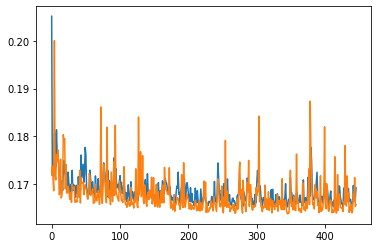

In [364]:
sns.lineplot(data=history.history['loss'])
sns.lineplot(data=history.history['val_loss'])

In [365]:
encoder_trained = best_autencoder.layers[1]
encoder_trained.trainable = True

In [382]:
input_layer = tf.keras.layers.Input(shape=10,)

x = encoder_trained(input_layer)
x = tf.keras.layers.Concatenate()([x, input_layer])
x = tf.keras.layers.Dense(50, activation='tanh')(x)
x = tf.keras.layers.Dropout(1/10)(x)
x = tf.keras.layers.Dense(40, activation='tanh')(x)
x = tf.keras.layers.Dropout(1/10)(x)
x = tf.keras.layers.Dense(25, activation='tanh')(x)
x = tf.keras.layers.Concatenate()([x, input_layer])
x = tf.keras.layers.Dense(30, activation='tanh')(x)
x = tf.keras.layers.Dropout(1/10)(x)
x = tf.keras.layers.Dense(25, activation='tanh')(x)
x = tf.keras.layers.Dropout(1/10)(x)
x = tf.keras.layers.Dense(20, activation='tanh')(x)
x = tf.keras.layers.Dropout(1/10)(x)
x = tf.keras.layers.Dense(10, activation='tanh')(x)
x = tf.keras.layers.Dense(5,  activation='tanh')(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

final_model = tf.keras.Model(inputs=input_layer, outputs=x)

In [383]:
final_model.compile(optimizer='adam',
                    loss='binary_crossentropy',metrics=['mse','mae'])

In [385]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss',patience=50),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5',monitor="val_loss",)
]

In [386]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 classes=np.unique(y_train),
                                                    y=y_train)

class_weight_dict = dict(enumerate(class_weights))

In [387]:
#class_weight_dict = {0: 0.5264550264550265, 1: 9.95}

In [388]:
y_train = np.array(y_train, dtype='float32')
y_test = np.array(y_test, dtype='float32')

history = final_model.fit(X_train, 
                          y_train, 
                          validation_data=(X_test, y_test), 
                          epochs=5000, 
                          callbacks=callbacks, 
                          class_weight=class_weight_dict)

Epoch 1/5000
511/511 [==============================] - 2s 2ms/step - loss: 0.1554 - mse: 0.0362 - mae: 0.1053 - val_loss: 0.0806 - val_mse: 0.0154 - val_mae: 0.0468
Epoch 2/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0815 - mse: 0.0171 - mae: 0.0438 - val_loss: 0.0699 - val_mse: 0.0148 - val_mae: 0.0321
Epoch 3/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0738 - mse: 0.0160 - mae: 0.0358 - val_loss: 0.0562 - val_mse: 0.0115 - val_mae: 0.0288
Epoch 4/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0676 - mse: 0.0149 - mae: 0.0324 - val_loss: 0.0536 - val_mse: 0.0120 - val_mae: 0.0239
Epoch 5/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0669 - mse: 0.0149 - mae: 0.0314 - val_loss: 0.0596 - val_mse: 0.0131 - val_mae: 0.0228
Epoch 6/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0645 - mse: 0.0147 - mae: 0.0305 - val_loss: 0.0398 - val_mse: 0.0082 - val_mae: 0.0191
Epoc

511/511 [==============================] - 1s 2ms/step - loss: 0.0416 - mse: 0.0093 - mae: 0.0183 - val_loss: 0.0320 - val_mse: 0.0070 - val_mae: 0.0118
Epoch 51/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0330 - mse: 0.0069 - mae: 0.0140 - val_loss: 0.0382 - val_mse: 0.0080 - val_mae: 0.0131
Epoch 52/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0396 - mse: 0.0085 - mae: 0.0172 - val_loss: 0.0337 - val_mse: 0.0072 - val_mae: 0.0115
Epoch 53/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0434 - mse: 0.0096 - mae: 0.0185 - val_loss: 0.0458 - val_mse: 0.0095 - val_mae: 0.0171
Epoch 54/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0423 - mse: 0.0092 - mae: 0.0190 - val_loss: 0.0986 - val_mse: 0.0227 - val_mae: 0.0340
Epoch 55/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0439 - mse: 0.0097 - mae: 0.0205 - val_loss: 0.0390 - val_mse: 0.0079 - val_mae: 0.0127
Epoch 56/500

511/511 [==============================] - 1s 2ms/step - loss: 0.0310 - mse: 0.0065 - mae: 0.0134 - val_loss: 0.0266 - val_mse: 0.0059 - val_mae: 0.0108
Epoch 100/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0270 - mse: 0.0059 - mae: 0.0128 - val_loss: 0.0280 - val_mse: 0.0062 - val_mae: 0.0097
Epoch 101/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0263 - mse: 0.0058 - mae: 0.0116 - val_loss: 0.0325 - val_mse: 0.0076 - val_mae: 0.0109
Epoch 102/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0298 - mse: 0.0066 - mae: 0.0124 - val_loss: 0.0480 - val_mse: 0.0104 - val_mae: 0.0157
Epoch 103/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0304 - mse: 0.0069 - mae: 0.0137 - val_loss: 0.0228 - val_mse: 0.0050 - val_mae: 0.0098
Epoch 104/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0314 - mse: 0.0067 - mae: 0.0127 - val_loss: 0.0402 - val_mse: 0.0096 - val_mae: 0.0137
Epoch 1

Epoch 148/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0208 - mse: 0.0041 - mae: 0.0092 - val_loss: 0.0286 - val_mse: 0.0063 - val_mae: 0.0098
Epoch 149/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0348 - mse: 0.0078 - mae: 0.0159 - val_loss: 0.0368 - val_mse: 0.0078 - val_mae: 0.0122
Epoch 150/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0239 - mse: 0.0048 - mae: 0.0102 - val_loss: 0.0283 - val_mse: 0.0060 - val_mae: 0.0095
Epoch 151/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0217 - mse: 0.0045 - mae: 0.0093 - val_loss: 0.0225 - val_mse: 0.0047 - val_mae: 0.0083
Epoch 152/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0196 - mse: 0.0041 - mae: 0.0082 - val_loss: 0.0186 - val_mse: 0.0038 - val_mae: 0.0060
Epoch 153/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0222 - mse: 0.0048 - mae: 0.0095 - val_loss: 0.0169 - val_mse: 0.0032 - val_mae:

Epoch 197/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0247 - mse: 0.0054 - mae: 0.0102 - val_loss: 0.0333 - val_mse: 0.0068 - val_mae: 0.0103
Epoch 198/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0156 - mse: 0.0030 - mae: 0.0063 - val_loss: 0.0193 - val_mse: 0.0034 - val_mae: 0.0059
Epoch 199/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0224 - mse: 0.0048 - mae: 0.0091 - val_loss: 0.0316 - val_mse: 0.0066 - val_mae: 0.0096
Epoch 200/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0215 - mse: 0.0047 - mae: 0.0100 - val_loss: 0.0256 - val_mse: 0.0048 - val_mae: 0.0080
Epoch 201/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0326 - mse: 0.0067 - mae: 0.0121 - val_loss: 0.0211 - val_mse: 0.0042 - val_mae: 0.0090
Epoch 202/5000
511/511 [==============================] - 1s 2ms/step - loss: 0.0165 - mse: 0.0033 - mae: 0.0076 - val_loss: 0.0170 - val_mse: 0.0032 - val_mae:

<AxesSubplot:>

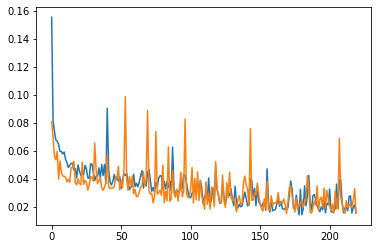

In [389]:
sns.lineplot(data=history.history['loss'])
sns.lineplot(data=history.history['val_loss'])

In [390]:
best_model = tf.keras.models.load_model('best_model.h5')

In [391]:
y_pred = best_model.predict(X_test)

In [392]:
from sklearn.metrics import classification_report

In [393]:
y_pred_class = np.where(y_pred > 0.5, 1,0)
print(classification_report(y_test,y_pred_class,))

              precision    recall  f1-score   support

         0.0       1.00      0.99      1.00      2048
         1.0       0.99      1.00      1.00      2037

    accuracy                           1.00      4085
   macro avg       1.00      1.00      1.00      4085
weighted avg       1.00      1.00      1.00      4085



In [394]:
from sklearn.metrics import ConfusionMatrixDisplay

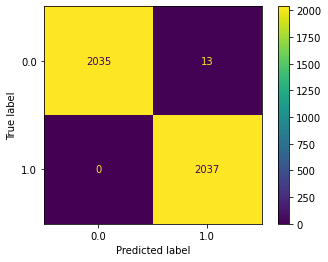

In [395]:
ConfusionMatrixDisplay.from_predictions(y_test,y_pred_class,)

In [400]:
from sklearn.manifold import TSNE

encoded = encoder_trained.predict(X)

X_embedded = TSNE(n_components=2,learning_rate='auto',init='random').fit_transform(encoded)

In [405]:
df = pd.DataFrame(X_embedded, columns=['C1','C2'])

<AxesSubplot:xlabel='C1', ylabel='C2'>

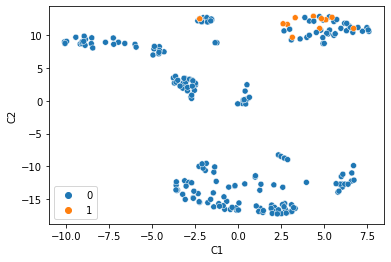

In [411]:
sns.scatterplot(x=df['C1'], y=df['C2'], hue=y.to_numpy())

In [396]:
X = pd.read_csv('final_dataset.csv').set_index(['bank','year'])
y = X.pop('y')

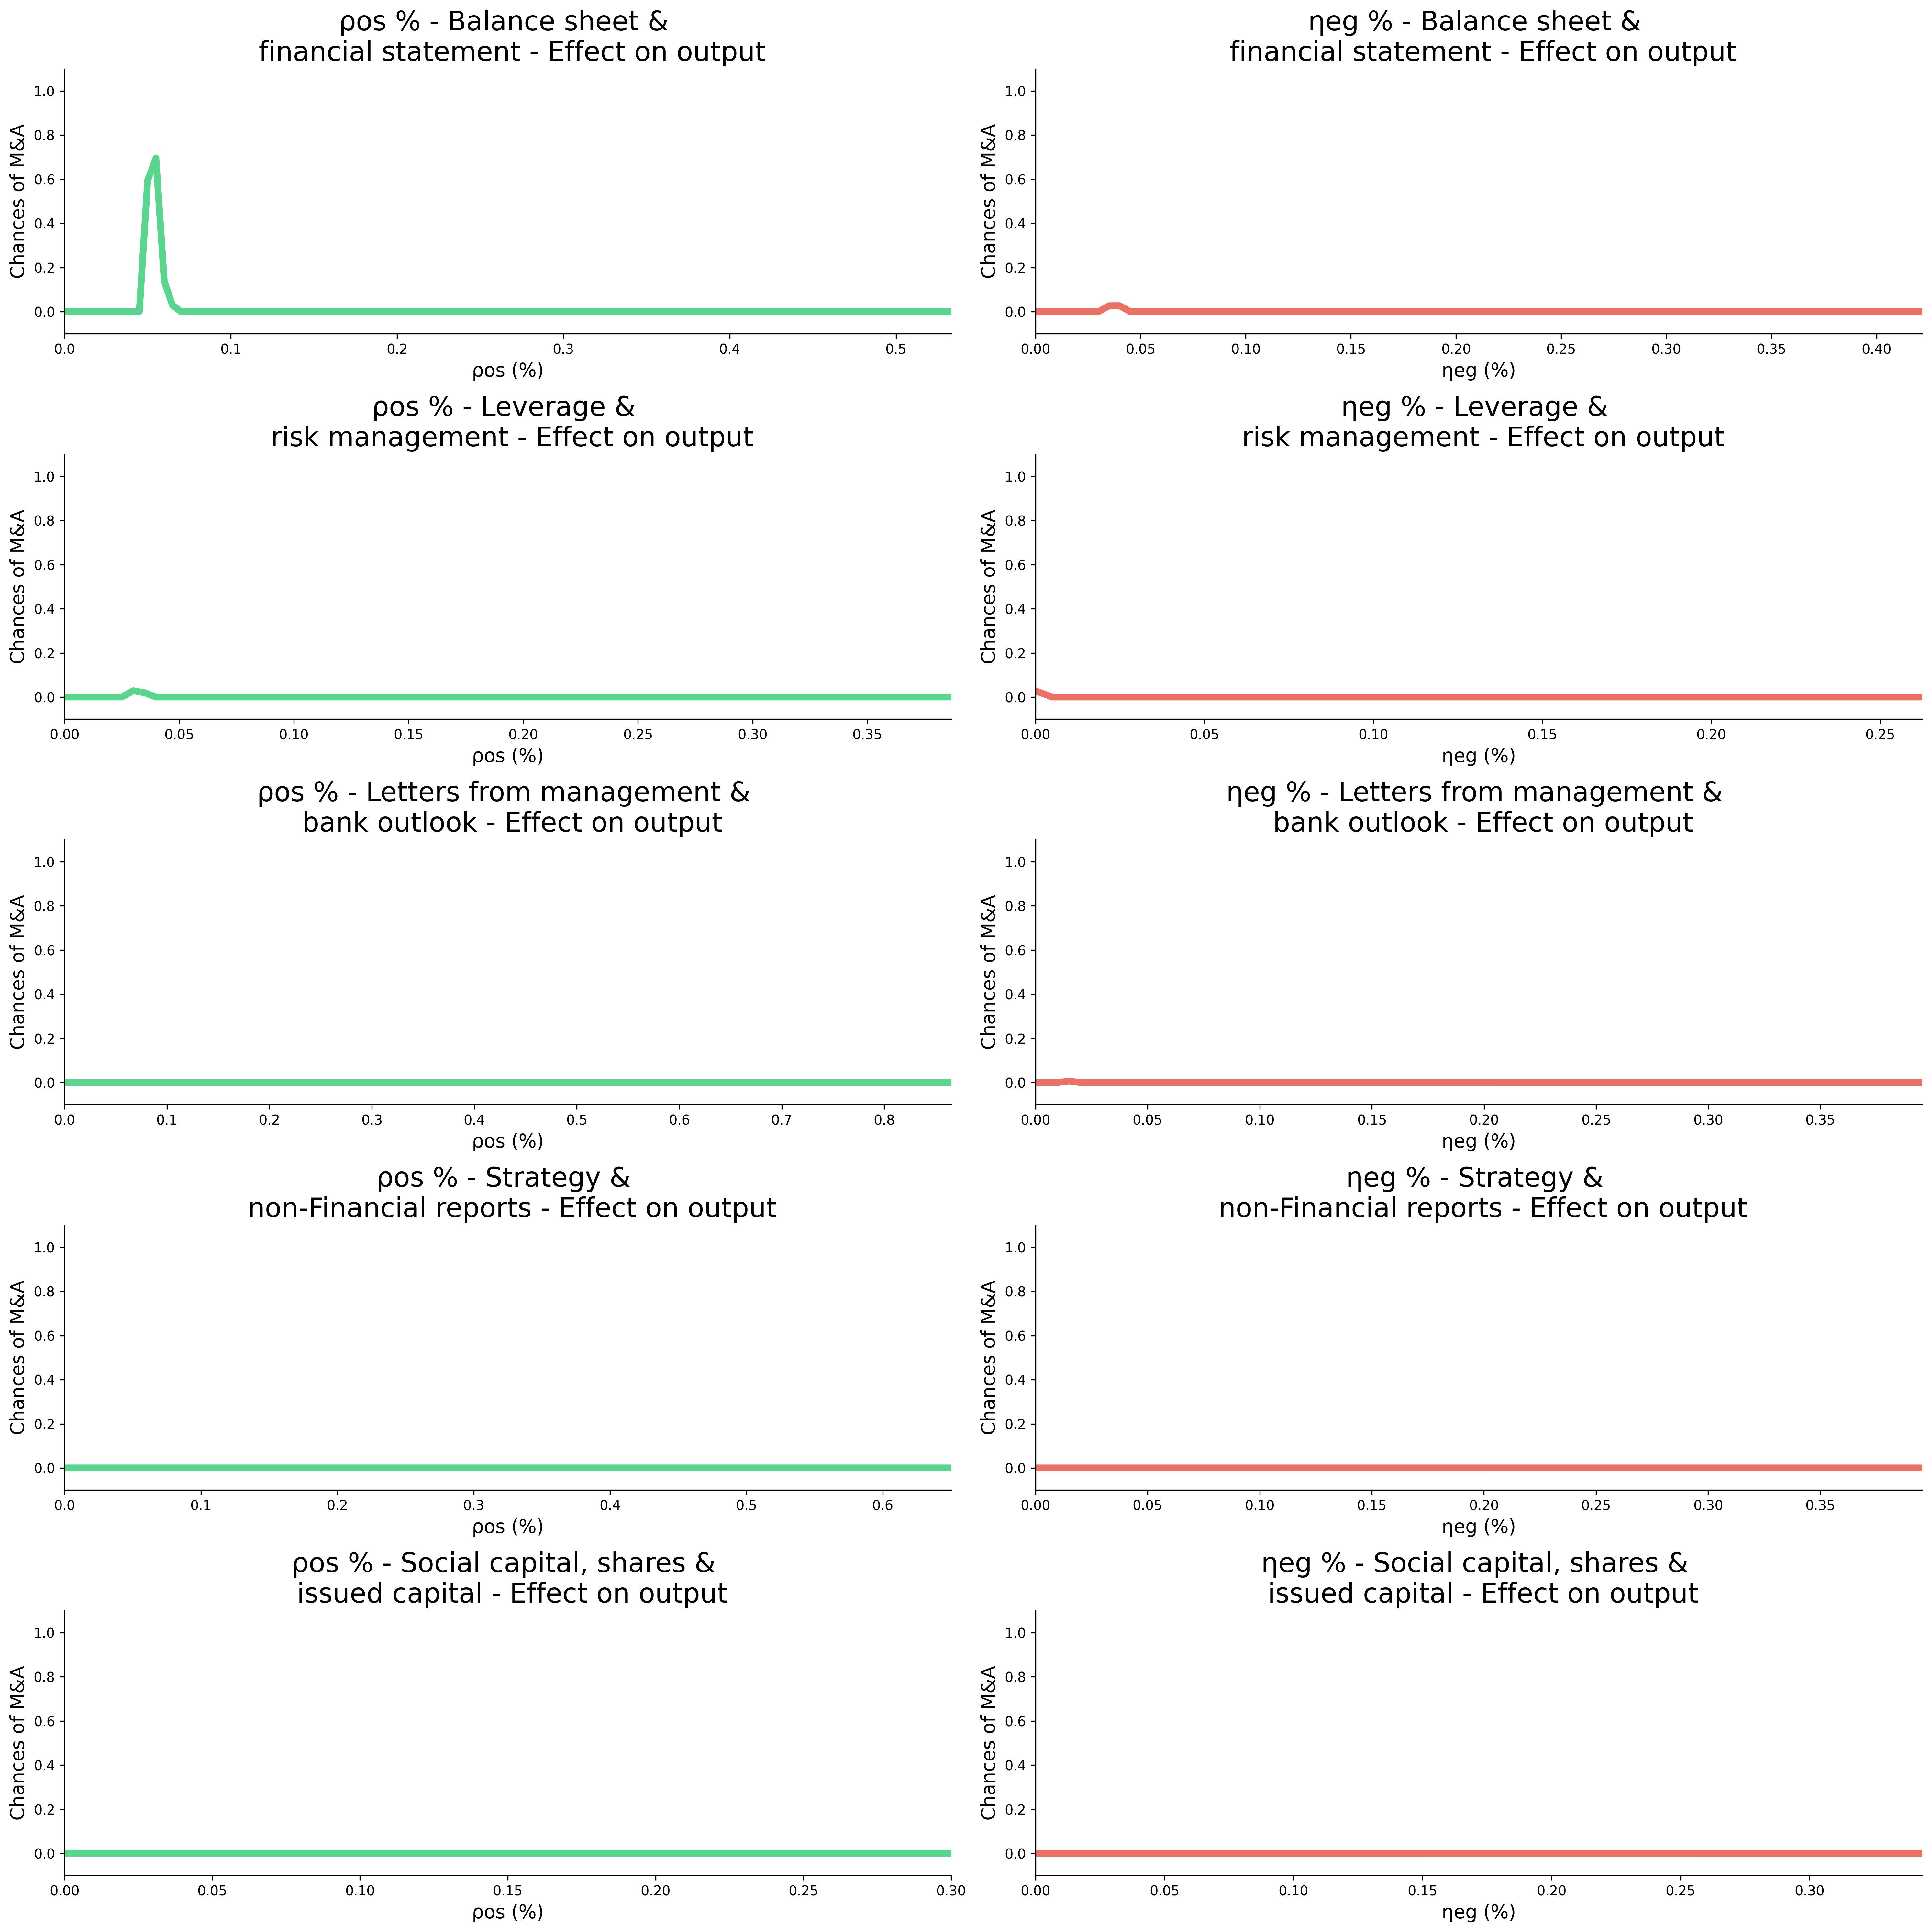

In [397]:
fig, axes = plt.subplots(figsize=(20,20), ncols=2, nrows=5, dpi=300)
fax = axes.flatten()

cols = ['pos_cluster_1', 'neg_cluster_1', 'pos_cluster_2', 'neg_cluster_2', 'pos_cluster_3', 'neg_cluster_3', 'pos_cluster_4', 
        'neg_cluster_4','pos_cluster_0',  'neg_cluster_0']

titles = {
    '1': 'Balance sheet & \n financial statement',
    '2': 'Leverage & \n risk management',
    '3': 'Letters from management & \n bank outlook',
    '4': 'Strategy & \n non-Financial reports',
    '5': 'Social capital, shares & \n issued capital',
}

model_logreg = load(path_modelo_logreg)

for ax, col in zip(fax, cols):
    variable = np.arange(0,1,0.005)
    dataframe = np.repeat([np.array(X.mean())], len(variable) , axis=0)

    dataframe = pd.DataFrame(dataframe, columns=X.columns)
    dataframe[col] = variable
    
    var_name = col.split('_')
    var_sent = 'ρos' if var_name[0]=='pos' else 'ηeg'
    line_color = '#58d68d' if var_name[0]=='pos' else '#ec7063'
    var_clst = var_name[-1] if var_name[-1] != "0" else "5"
    sns.lineplot(y=final_model.predict(dataframe)[:,0], x=variable, ax=ax, linewidth=5, color=line_color)
    
    ax.set_title(f'{var_sent} % - {titles[var_clst]} - Effect on output', size=20)
    ax.set_ylim([-0.1,1.1])
    ax.set_xlim([0,X.max()[col]+0.2])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f'{var_sent} (%)', size=14)    
    ax.set_ylabel(f'Chances of M&A', size=14)

plt.tight_layout()
plt.show()